In [78]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [79]:
def center_crop(img, cut_width, cut_height):
    width, height = img.shape[1], img.shape[0]
    new_width = width - cut_width
    new_height = height - cut_height
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    return img[int(top):int(bottom), int(left):int(right)]

In [80]:
def crop_rotation(image, box, height, width):
    

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height],
                        [0, 0],
                        [width, 0],
                        [width, height]], dtype="float32")

    M = cv.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv.warpPerspective(image, M, (width, height))
    return warped

In [81]:
def thresh_split_chanel(img, thresh1, thresh2):
    gray1 = img[:,:,1]
    mask1 = cv.inRange(gray1, 0, thresh1) #90
    gray2 = img[:,:,2]
    mask2 = cv.inRange(gray2, thresh2, 255) #130
    # combine white part of both images
    mask = cv.bitwise_or(mask1, mask2)
    return mask

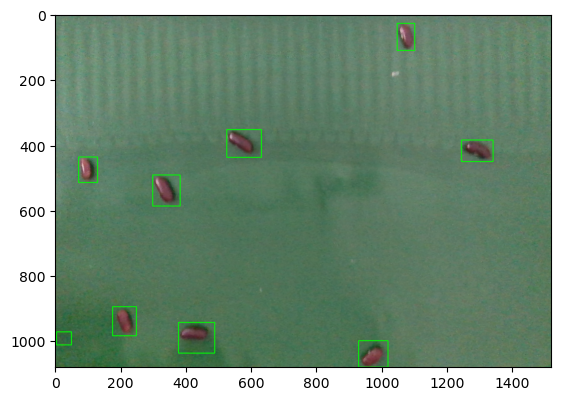

In [82]:
img = cv.imread('/home/dotronghiep/Documents/Datasets/Anomaly_Detection/test_bounding_box/train/15.png')
min_height = 30
min_width = 30
img = center_crop(img, cut_width=100, cut_height=0)
# Đọc ảnh và chuyển đổi sang grayscale
plt.imshow(img[:,:,::-1])

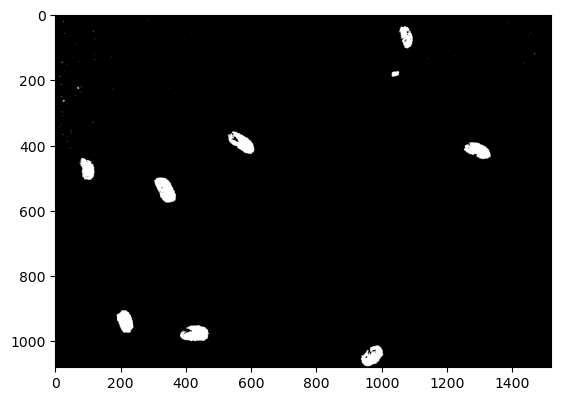

In [83]:
thresh = thresh_split_chanel(img, 80, 130)
plt.imshow(thresh, cmap='gray')

In [84]:
# gray = img[:,:,1] # Chọn kênh màu xanh
# plt.imshow(gray, cmap='gray')

In [85]:
# low_thresh = 95  # Ngưỡng dưới
# high_thresh = 170  # Ngưỡng trên

# # Áp dụng ngưỡng kép
# mask = cv.inRange(gray, low_thresh, high_thresh)

# # Đảo ngược mask để có vùng nằm ngoài phạm vi thành màu trắng và phần còn lại màu đen
# thresh = cv.bitwise_not(mask)

# # Hiển thị ảnh kết quả
# plt.imshow(thresh, cmap='gray')

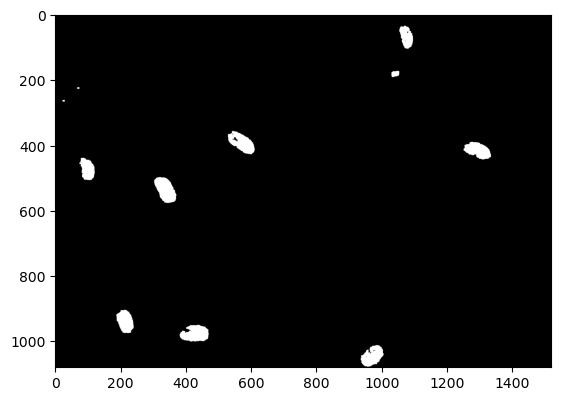

In [86]:
# Loại bỏ nhiễu và xác định vùng nền chắc chắn
kernel = np.ones((3, 3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=1)
sure_bg = cv.dilate(opening, kernel, iterations=1)
plt.imshow(sure_bg, cmap='gray')

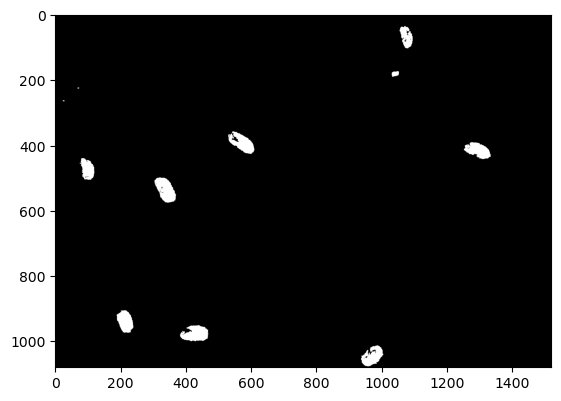

In [87]:
# Xác định vùng chữ chắc chắn
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
_, sure_fg = cv.threshold(dist_transform, 0 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
plt.imshow(sure_fg, cmap='gray')

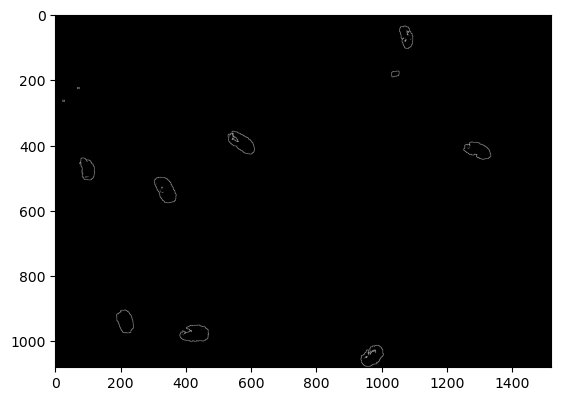

In [88]:
# Xác định vùng không xác định
unknown = cv.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='gray')

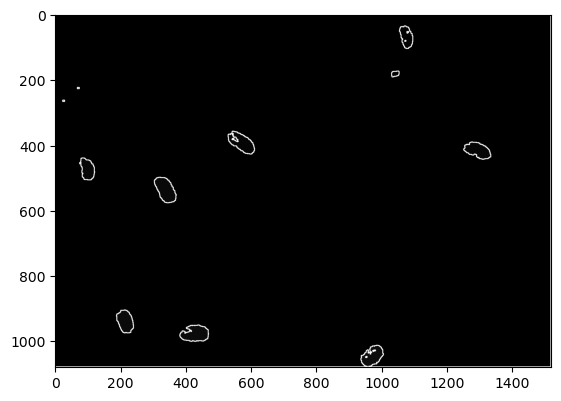

In [89]:
# Nhãn các vùng
_, markers = cv.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Watershed
markers = cv.watershed(img, markers)

# Tăng kích thước các đường viền
markers = markers.astype(np.uint8)
kernel_dilate = np.ones((3, 3), np.uint8)
markers = cv.dilate(markers, kernel_dilate, iterations=1)

plt.imshow(markers, cmap='gray')

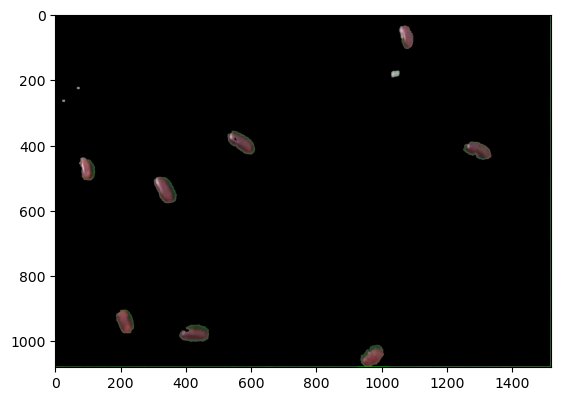

In [90]:
non_background = img.copy()
non_background[markers==1] = 0

objects = np.logical_and(markers != 1, markers != 255)
plt.imshow(non_background[:,:,::-1])

In [91]:
def non_max_suppression(img, boxes, scores, iou_threshold):
    # Sắp xếp hộp giới hạn theo điểm số tin cậy giảm dần
    indices = np.argsort(scores)[::-1]
    keep = []
    boxes = np.array([
        [box[0], box[1], box[0] + box[2], box[1] + box[3]]
        for box in boxes
    ])
    
    while len(indices) > 0:
        # Giữ lại hộp giới hạn có điểm số tin cậy cao nhất
        current_index = indices[0]
        keep.append(current_index)

        # Lấy hộp giới hạn hiện tại
        current_box = boxes[current_index]
        # print("current_box",current_box)
        
        # So sánh hộp giới hạn này với những hộp còn lại
        remaining_indices = indices[1:]
        remaining_boxes = boxes[remaining_indices]
        # Tính toán IoU giữa hộp giới hạn được giữ và những hộp còn lại
        x1 = np.maximum(current_box[0], remaining_boxes[:, 0])
        y1 = np.maximum(current_box[1], remaining_boxes[:, 1])
        x2 = np.minimum(current_box[2], remaining_boxes[:, 2])
        y2 = np.minimum(current_box[3], remaining_boxes[:, 3])
        # Tính diện tích giao cắt
        # print( "inter",np.maximum(0, x2 - x1) ,np.maximum(0, y2 - y1))
        intersection = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)

        # print("intersection",intersection)
        # Tính diện tích của hộp giới hạn hiện tại và hộp còn lại
        area_current_box = (current_box[2] - current_box[0]) * (current_box[3] - current_box[1])
        area_remaining_boxes = (remaining_boxes[:, 2] - remaining_boxes[:, 0]) * (remaining_boxes[:, 3] - remaining_boxes[:, 1])
        
        # # Tính diện tích hợp (union)
        union = area_current_box + area_remaining_boxes - intersection
        
        # Tính IoU
        iou = intersection / union
        
        # Loại bỏ các hộp giới hạn có IoU lớn hơn ngưỡng
        filtered_indices = remaining_indices[iou <= iou_threshold]
        indices = filtered_indices
    
    # Trả về danh sách các chỉ mục của hộp giới hạn được giữ
    return keep


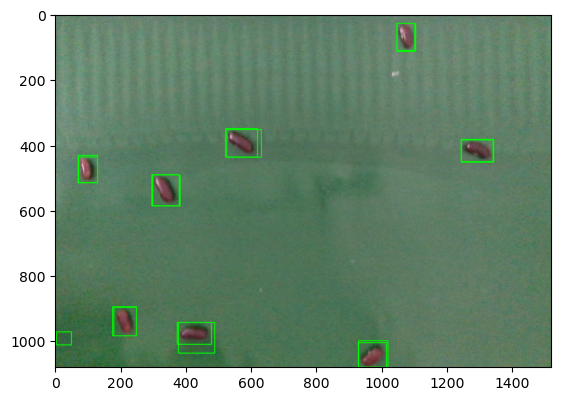

In [92]:
# Find contours in the binary_markers image
contours, _ = cv.findContours(objects.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

scores = []

# Tính toán điểm số dựa trên diện tích vùng
for contour in contours:
    # Tính toán diện tích của contour
    area = cv.contourArea(contour)
    # Thêm diện tích vào danh sách điểm số
    scores.append(area)

indexes = non_max_suppression(img, np.array([cv.boundingRect(contour) for contour in contours]),scores, 0)
# contours = [contours[i] for i in indexes]

for i, contour in enumerate(contours):    
# Tính toán hình chữ nhật có diện tích nhỏ nhất bao quanh contour
    # print(box)
    x, y, w, h = cv.boundingRect(contour)
    if w > min_width and h > min_height:
        cv.rectangle(img, (x-10, y-10), (x+w+10, y+h+10), (0, 255, 0), 2)

plt.imshow(img[:,:,::-1])

